## Alt-Clinic (COVID-19 data)

Please continue reading if you (alternatively) would like to work with the recent COVID-19 data. The data (per country) are provided **daily** via this GitHub repository https://github.com/CSSEGISandData/COVID-19.

You are going to follow a similar approach as above, but adapted using the following steps:

- [x] Start by exploring the plot of the COVID-19 cases (in total) and justify the exponential rate of increase
- [x] Proper visualizations of the timeseries

Obviously, one interesting task is to compare how new infection cases appear in different countries and if there is a similarity in the evolution of these timeseries, i.e. can we assume that the timeseries evolution of infections in the Netherlands will have the same evolution as in e.g. China or Italy?

- [x] Provide commentary on the problems that arise from the selection bias introduced by different ways that countries handle reporting. If you find fit, do some research into how countries do tests and how do they report their cases
- [x] Provide commentary (and eventually a solution) of the "start day problem" of the timeseries: The problem is that while in China the outbreak was already in January, in Italy it was in late February and in the Netherlands is not quite yet determined(?). Define your "day 0" properly: If you look online, some people consider as day 0, either the day that the country reported the first infection, or the day that a cummulative amount of e.g. 50 infections were reported, or you might think of something else. The reason for this is to have a proper comparison metric for the timeseries of different countries.
* [x] Pick some countries (incl. Netherlands) and visualize the results on this "shifted"/"normalized" time-scale
* Report preliminary results on the visual inspection of the plots **TODO: Normalize those plots by population density. Show top/bottom countries in Europer and Asia**

And now for the most challenging task, let's try to predict! The real challenge here is that we don't have enough data points for having accurate train/test models, so you have to think of a work-around (e.g. fit model for a deep-in-the-outbreak-country like China and then try to see how that model performs on other countries).

Here are some steps to follow:

* Try to fit an ARIMA model for predicting the evolution of the infected cases worldwide
* Try to fit an ARIMA model for a specific country (e.g. China).
* Use this guide (http://people.duke.edu/~rnau/arimrule.htm) as indicative rules for which model fits the best
* As the situation evolves and since the clinic is delivered in one week, you can use "real" world data for testing! Make sure to download the data every day and check your model prediction.
* Show your predictions in a plot
* Evaluate your models using MAE, MSE and R-squared

Since this is "extra-ordinary" conditions, let me(us) know how we can help you more into this or if you have any other cool idea. 

Stay healthy and enjoy!

### Ideas
* stationarize?
* correlogram


In [69]:
import IPython.core.display
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
from scipy.stats import *

%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (18, 6)
matplotlib.rcParams['lines.linewidth'] = 1
sns.set(style="ticks")
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [70]:
path = "data/time_series_19-covid-"
confirmed = pd.read_csv(path+"Confirmed.csv",keep_default_na=False)
deaths = pd.read_csv(path+"Deaths.csv",keep_default_na=False)
recovered = pd.read_csv(path+"Recovered.csv",keep_default_na=False)

In [71]:
dfs = [confirmed, deaths,recovered]

In [72]:
colors = ['y','r','g']

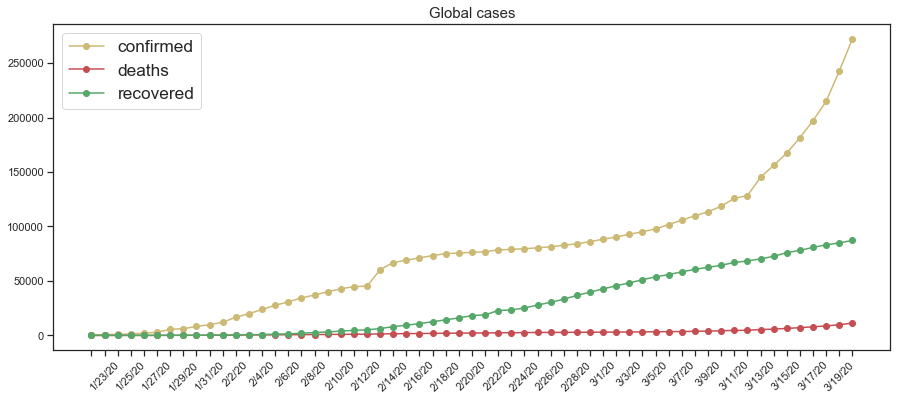

In [73]:
plt.figure(figsize=(15, 6))
for i,df in enumerate(dfs):
    total_cases = df.iloc[:,4:].sum()
    plt.plot(total_cases.index,total_cases.values,'-o'+colors[i])
plt.xticks(rotation=45)
plt.legend(labels=['confirmed','deaths','recovered'],loc='upper left',fontsize='x-large')
plt.title('Global cases',fontsize=15)
# show only every second x-label to make the x-axis less cluttered
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
for label in temp[::2]:
    label.set_visible(False)
plt.show()

From [Wikipedia](https://en.wikipedia.org/wiki/Exponential_growth) (aka The Most Reliable and Academic Source Possible &trade;): "Exponential growth is a specific way that a quantity may increase over time. It occurs when the instantaneous rate of change (that is, the derivative) of a quantity with respect to time is proportional to the quantity itself."

Furthermore, as presented by [3Blue1Brown](https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be), we can model the rate of change of covid-19 cases in the following manner:
#### $\Delta N_d = E \cdot p \cdot N_d$
where:
* $N_d$ - number of cases on a given day
* $E$ - avg. number of people that are exposed to an infected person each day
* $p$ - probability of each exposure becoming an infection

In plain English:
* the more people are in contact with infected people, the faster the number of cases increases (this is why social distancing is so important)
* the higher the probability of an exposure becoming an infection, the faster the number of cases increases (this why taking prevention measures, such as washing hands more often, is so important)
* and finally, the higher the number of cases, the faster the number of cases increases ($\Delta N_d$ is proportional to $N_d$)

The last bullet point proves that we are dealing with an exponential growth (by definition).

## Comparison of the virus spread between countries

For large countries such as US or China, the original data shows numbers for separate states/regions, therefore we aggregate everything per country.

In [74]:
confirmed_per_country = confirmed.groupby(by='Country/Region').sum().drop(['Lat', 'Long'], 1)

### Testing

The confirmed cases only indicate the number of people that were tested positive against coronavirus. However, it is certain that there are more actual cases which are not detected. Number of tests made varies between countries, for example in Guangdong Province in China already 320,000 tests have been performed while in many countries testing has not even started yet (https://ourworldindata.org/coronavirus-testing-source-data). Due to limited supply of tests, each country follows a different criteria when selecting people for testing. Some only test people with severe symptoms or those that travelled to high risk countries like China (https://www.npr.org/sections/health-shots/2020/03/14/815727231/opinion-early-coronavirus-testing-failures-will-cost-lives?t=1584359012219). "China’s National Health Commission has now revised national guidelines on responding to the COVID-19 outbreak at least six times since Jan. 22. Two of those changes implemented after Feb. 12 have substantially changed daily case counts." (https://www.cnbc.com/2020/02/26/confusion-breeds-distrust-china-keeps-changing-how-it-counts-coronavirus-cases.html). Due to those differences, it is difficult to verify the reliability of the data.

### Start day problem
After examining the data, I decided to set the start day as the first day when more than 10 cases has been confirmed in a country. This is because for many countries in the first few days the test cases are constant (which is highly improbable and reflects errors in testing rather than the actual information) and only after a few days pass (and more cases are confirmed) the numbers seem plausible. Below we can see an example of Afghanistan where according to the data there was only one test confirmed for 13 days.

In [75]:
confirmed_per_country.loc['Afghanistan','2/23/20':'3/8/20']

2/23/20    0
2/24/20    1
2/25/20    1
2/26/20    1
2/27/20    1
2/28/20    1
2/29/20    1
3/1/20     1
3/2/20     1
3/3/20     1
3/4/20     1
3/5/20     1
3/6/20     1
3/7/20     1
3/8/20     4
Name: Afghanistan, dtype: int64

### Normalize countries to facilitate comparison

Parts of the code below are inspired by: https://stackoverflow.com/questions/56757092/find-first-and-last-non-zero-column-in-each-row-of-a-pandas-dataframe

In [76]:
start_day_criteria = confirmed_per_country < 10
# for each country, get the first column where # cases surpassed 10
start_date = confirmed_per_country.mask(start_day_criteria).apply(pd.Series.first_valid_index, 1).dropna()

In [77]:
dates = list(confirmed_per_country.columns)
normalized = pd.DataFrame(index=start_date.index, columns=confirmed_per_country.columns)
# for each country (each row)
for country in start_date.index:
#     compute how much the row needs to be shifted
    lag = dates.index(start_date[country])
#     shift the row by lag
    normalized.loc[country,:] = confirmed_per_country.shift(periods=-lag,axis=1).loc[country]

# the dates in columns are not relevant anymore, change them to numbers
normalized.columns = range(len(normalized.columns))

In [78]:
def plot_ts_plotly(normalized, countries):
    fig = go.Figure()
    for country in countries:
        df = normalized.loc[country]
        if country=='China':
            fig.add_trace(go.Scatter(x=df.index, y=df.values,mode='lines+markers',name=country,marker_color='green'))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=df.values,mode='lines',name=country))
    fig.update_layout(title={
        'text': 'Confirmed cases per country (before shifting China)',
        'x':0.5},xaxis={'range':[0,30]})
    fig.show()

In [79]:
countries = normalized.index
plot_ts_plotly(normalized, countries)

The green line with markers representing China is sky-rocketing compared to other countries. Was the virus spread in China so terriyfing? No, the reason for such striking result is the following:

The first date in the dataset is January 21st, however according to [WHO](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf?sfvrsn=20a99c10_4) there were already cases in the very beginning of the year. [The Guardian](https://www.theguardian.com/world/2020/mar/13/first-covid-19-case-happened-in-november-china-government-records-show-report) reports that the first case of Covid-19 in China occured even in November. Thus the first number for China in this dataset iss after at least 21 days of the virus already present in the country which might lead to wrong conclusions in visualizations. Therefore I decided to shift China's data by 21 days ahead in the normalized data frame. I filled in the newly created missing values with the first number of confirmed cases (548). If we see a country that wasn't infected for 21 days yet, but number of its cases are already above China's line, we might reason that the rate of increase in this country is alarming.

In [80]:
first_number = normalized.loc['China'][0]
normalized.loc['China'] = normalized.shift(periods=21,axis=1).loc['China']
normalized.loc['China'] = normalized.loc['China'].fillna(first_number)

In [100]:
countries = ['Netherlands','China','Poland']
plot_ts_plotly(normalized, countries)

After applying this modification, China doesn't seem be doing that bad after all. In fact, there are several countries with higher derivative of cases, such as Italy (dark yellow), Iran (cyan) or Spain (blue).

Now, let us zoom in on a few countries in Europe

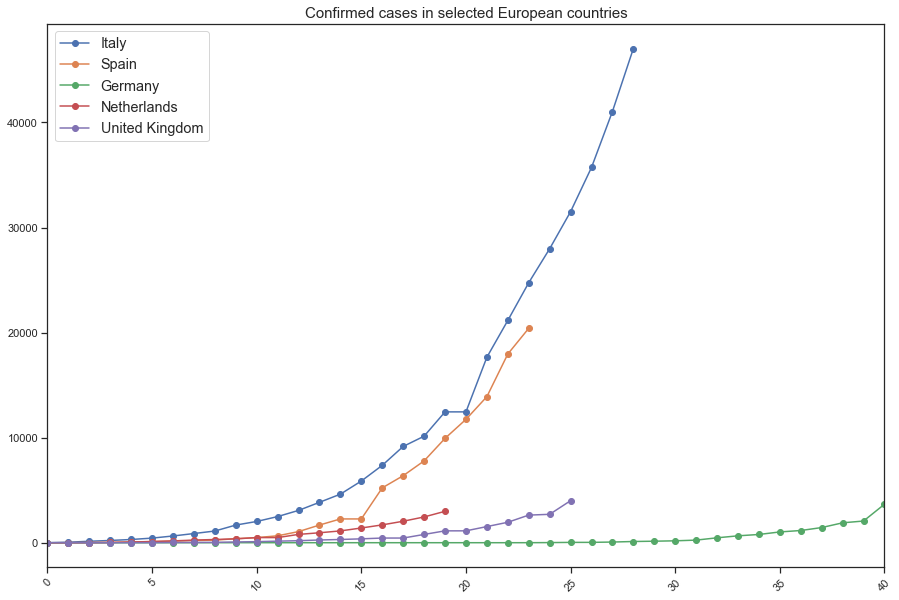

In [82]:
countries = ['Italy','Spain','Germany','Netherlands','United Kingdom']
def plot_ts_pyplot(normalized, countries):
    plt.figure(figsize=(15, 10))
    for i in countries:
        df = normalized.loc[i]
        plt.plot(df.index,df.values,'-o')
    plt.xticks(rotation=45)
    plt.xlim(0,40)
    plt.legend(labels=countries,loc='upper left',fontsize='large')
    plt.title('Confirmed cases in selected European countries',fontsize=15)
    plt.show()

plot_ts_pyplot(normalized, countries)

As we already observed, curves corresponding to Italy and Spain are very steep. On the other hand, Germany has a pretty flat curve and Netherlands togethr with UK are somewhere in the middle.

## Correlation with population density in Europe

In theory, given all other factors (prevention measures, test coverage etc.) equal, the spread rate should be correlated to the density population of countries*. The intuition is simple - an individual living in highly populated areas, encounters more people throughout the day (in public transport, work, shops) and the more people they encounter, the higher the chance that someone they meet is infected. This is connected to the aforementioned $E$ variable. According to the formula higher $E$ leads to higher $\Delta N_d$ which obviously leads to higher $N_d$. Let us verify this hypothesis.

\* Another assumption that we need to make is that the population density is uniform across the whole country which is not true in real life, e.g. people accumulate in large cities.

### Load and process data

**Density data:** https://ourworldindata.org/most-densely-populated-countries<br>
**Country and continent names data:** https://datahub.io/JohnSnowLabs/country-and-continent-codes-list#data

In [101]:
density = pd.read_csv("data/population-density.csv").drop(['Code'],axis=1)
density = density[density.Year==2017]

In [102]:
# rename a column to a shorter name
density.rename(columns={'Population density (people per sq. km of land area) (people per km² of land area)':'Density'}, 
                 inplace=True)

In [103]:
countries = pd.read_csv("data/country-list.csv")

In [108]:
# shorten country names, for example from "Albania, Republic of" to "Albania"
for i in countries.index:
    split = countries.at[i,'Country_Name'].split(',')
    if len(split)>0: 
        countries.at[i,'Country_Name'] = split[0] 

# rename remaining countries
eu_countries.loc[eu_countries.Country_Name=='Slovakia (Slovak Republic)','Country_Name'] = 'Slovakia'
eu_countries.loc[eu_countries.Country_Name.str.startswith('United Kingdom'),'Country_Name'] = 'United Kingdom'
eu_countries.loc[eu_countries.Country_Name=='Russian Federation','Country_Name'] = "Russia"

# select only european countries
eu_countries = countries[countries.Continent_Name=='Europe']

In [109]:
# merge to obtain a single table with densities and # cases in the 12th days
eu_density = pd.merge(density,eu_countries,left_on='Entity',right_on='Country_Name')[['Country_Name','Year','Density']]
eu_density = pd.merge(eu_density,normalized.reset_index()[['Country/Region',12]],left_on='Country_Name',right_on='Country/Region')
eu_density_cases = eu_density.dropna()
eu_density_cases[12] = eu_density_cases[12].astype(int) 

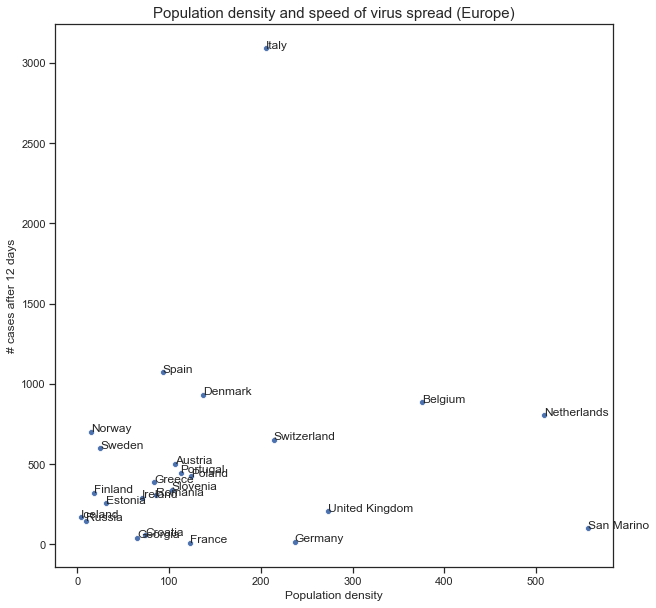

In [110]:
# fig, ax = plt.subplots()
plt.figure(figsize=(10,10))
sns.scatterplot(x='Density',y=12,data=eu_density_cases)
plt.ylabel('# cases after 12 days')
plt.xlabel('Population density')
plt.title('Population density and speed of virus spread (Europe)',fontsize=15)
for i in eu_density_cases.index:
    plt.annotate(eu_density_cases.at[i,'Country_Name'], (eu_density_cases.at[i,'Density'], eu_density_cases.at[i,12]))
plt.show()

In [107]:
pearson = pearsonr(eu_density_cases['Density'],eu_density_cases[12])[0]
spearman = spearmanr(eu_density_cases['Density'],eu_density_cases[12]).correlation
print("Perason correlation",pearson)
print("Spearman correlation",spearman)

Perason correlation -0.0941245222947966
Spearman correlation 0.020665901323451048


Both correlations are weak, population density is not significantly correlated with spread rate. Therefore we can reject our hypothesis which was predictable from the start given how many assumptions we made. Nevertheless, it is always a good idea to back up theory and intuition with quantative results.